In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import random
import imutils
import pandas as pd

# Parte 1

## Carregamento e remoção do background transparente

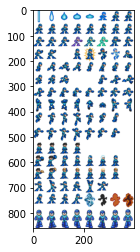

In [2]:
atlas = cv2.imread("atlas.png", cv2.IMREAD_UNCHANGED)
trans_mask = atlas[:,:,3] == 0
atlas[trans_mask] = [255, 255, 255, 255]
atlas = cv2.cvtColor(atlas, cv2.COLOR_BGRA2RGB)
plt.imshow(atlas)

In [3]:
def write_image(img, save=False, filename=-1):
     
    plt.imshow(img)
    plt.show()
    
    if save:
        print(filename)
        cv2.imwrite(f'./recortes do atlas/{filename}.png', cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        

def separate_columns(img):
    global img_count
    global cols
    col_mark = [-1, -1]
    #Procura colunas com informações, marcando o inicio e fim de partes com informações em col_mark
    for i in range(cols):
        if not (img[:, i] == [[255]*3] * img.shape[0]).all():
            if col_mark[0] == -1:
                col_mark[0] = i
            if i == (cols - 1) and col_mark[1] == -1:
                col_mark[1] = i + 1
                write_image(img[:, col_mark[0]:col_mark[1]], True, img_count)
                img_count += 1
                col_mark = [-1, -1]
        else:
            if col_mark[0] != -1:
                col_mark[1] = i
                write_image(img[:, col_mark[0]:col_mark[1]], True, img_count)
                
                img_count += 1
                col_mark = [-1, -1]
                

def separate_image(img):    
    row_mark = [-1, -1]   
    for j in range(rows):
        #Procura linhas com informações, marcando o inicio e fim de partes com informações em row_mark
        if not (img[j, :] == [[255]*3]*cols).all():
            if row_mark[0] == -1:
                row_mark[0] = j
            if j == (rows - 1) and row_mark[1] == -1:
                row_mark[1] = j + 1
                write_image(img[row_mark[0]:row_mark[1], :])
                separate_columns(img[row_mark[0]:row_mark[1], :])
        else:
            if row_mark[0] != -1:
                row_mark[1] = j + 1
                write_image(img[row_mark[0]:row_mark[1], :])
                
                separate_columns(img[row_mark[0]:row_mark[1], :])
                
                #reinicia o row_mark
                row_mark = [-1, -1]

## Separação das imagens

In [ ]:
rows, cols, _ = atlas.shape
img_count = 0
separate_image(atlas)

# Parte 2

## Carregamento

In [27]:
images_path = glob("./landscapes/*")

## Separação por aspect ratio

In [31]:
images_info = []
for image_path in images_path:
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    rows, columns = image.shape[:2]
    aspect_ratio = round(columns/rows, 3)
    image_info = {"path": image_path, "rows": rows, "columns": columns, 'aspect_ratio': aspect_ratio}
    images_info.append(image_info)

In [102]:
images_info_df = pd.DataFrame(images_info)

## Parametrização da imagem completa

In [103]:
max_col_allowed = 1920
rows_by_strip = 100
image_strips = 10
border = 5
tolerance = 1.05

images_info_df['rows'] = rows_by_strip
images_info_df['columns'] = images_info_df['aspect_ratio'] * images_info_df['rows']
images_info_df['columns'] = images_info_df['columns'].astype(int)

## Junção das imagens

In [104]:
def choose_image():
    global actual_col_len
    while True:
        if images_info_df['columns'].min() + actual_col_len + border > max_col_allowed * (2-tolerance):
            if images_info_df['columns'].min() + actual_col_len + border > 0.51 * max_col_allowed * tolerance:
                return None
            else:
                min_images = images_info_df.query(f"columns == {images_info_df['columns'].min()}")
                index = min_images.index.values[0]
                image = images_info_df.loc[[index]]
                actual_col_len += image['columns'].values[0] + border
                images_info_df.drop([index], inplace=True)
                return image.path.values[0]
        
        random_index = random.choice(list(images_info_df.index))
        image = images_info_df.loc[[random_index]]
        increase = image['columns'].values[0] + actual_col_len 
        
        if increase <= max_col_allowed * tolerance:
            actual_col_len += image['columns'].values[0] + border
            images_info_df.drop([random_index], inplace=True)
            return image.path.values[0]

In [ ]:
image_full = []
actual_col_len = 0
max_col_len = 0

while not images_info_df.empty and len(image_full) < image_strips:
    images = []
    while actual_col_len < max_col_allowed * tolerance:
        image = choose_image()
        if image == None:
            break
        else:
            images.append(image)
    image_full.append(images)
    
    if max_col_len < actual_col_len:
        max_col_len = actual_col_len
    actual_col_len = 0

In [ ]:
album = np.ones((rows_by_strip * ((len(image_full) + 10)), max_col_len, 3), dtype=int) * 255
used_rows = 0
for images in image_full:
    used_cols = 0
    
    for path_image in images:
        image = cv2.cvtColor(cv2.imread(path_image), cv2.COLOR_BGR2RGB)
        image = imutils.resize(image, height=rows_by_strip)
        rows, columns = image.shape[:2]
        album[used_rows:used_rows + rows, used_cols:used_cols + columns, :] = image
        used_cols += columns + border
        
    used_rows += rows_by_strip + border
    
plt.figure(figsize=(20,40))
plt.imshow(album)
plt.axis("off")
plt.savefig("./album.png")